In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Создание датасета

In [2]:
patch = r'I:\Хакатоны\Цифровой прорыв Пермь'
file_name = [r'\DTP.csv', r'\Fires.csv', r'\Incidents.csv', r'\Meteo data. MO and meteo accordance.csv', 
             r'\Meteo data.csv', r'\Natural incidents.csv',r'\Network deterioration.csv',
             r'\Temperature statistics.csv', r'\population.csv', r'\forest_square.csv']

In [3]:
incidents_dtp = pd.read_csv(patch+file_name[0])
incidents_dtp.head()

,Район,Тип выезда,Дата и время пожара,Причина
0,Пермский ГО,ДТП,2013-01-01 01:55:00,ДТП/Столкновение
1,ГО город Березники,ДТП,2013-01-01 04:20:00,ДТП/Столкновение наез на препятствие (столб)
2,Ильинский ГО,ДТП,2013-01-01 05:30:00,ДТП/Столкновение
3,Осинский ГО,ДТП,2013-01-01 06:19:00,ДТП/Столкновение опрокидывание в кювет
4,Куединский МО,ДТП,2013-01-01 08:00:00,ДТП/Столкновение


In [4]:
incidents_dtp['Причина'].nunique(), incidents_dtp.shape

(1144, (30699, 4))

In [5]:
incidents_fire = pd.read_csv(patch+file_name[1])
incidents_fire.head()

,Район,Тип выезда,Дата и время пожара,Причина
0,Пермский ГО,Пожар,2013-01-21 00:00:00,Умышл. действия по уничтож. (поврежд.) имущест...
1,Добрянский ГО,Пожар,2013-01-22 10:33:00,Нарушение правил тех. эксплуатации эл.оборудов...
2,Ильинский ГО,Пожар,2013-01-23 21:30:00,Умышл. действия по уничтож. (поврежд.) имущест...
3,Кунгурский МО,Пожар,2013-01-26 13:20:00,Умышл. действия по уничтож. (поврежд.) имущест...
4,Ильинский ГО,Пожар,2013-01-27 13:00:00,НППБ при эксплуатации бытовых эл.приборов


In [6]:
incidents_fire.shape, incidents_fire['Причина'].nunique()

((30207, 4), 111)

In [7]:
incidents = pd.read_csv(patch+file_name[2])
incidents['Район'].nunique()

63

In [8]:
incidents.shape, incidents['Тип'].nunique()

((3654, 3), 61)

In [9]:
meteo_st = pd.read_csv(patch+file_name[3])
meteo_st

,Муниципальное образование,Метеорологическая станция
0,Александровский МО,г. Березники
1,Бардымский МО,г. Оса
2,Березовский МО,г. Кунгур
3,Большесосновский МО,с. Большая Соснова
4,Верещагинский ГО,г. Верещагино
5,Гайнский МО,п. Гайны
6,ГО город Березники,г. Березники
7,ГО город Кизел,г. Губаха
8,Горнозаводский ГО,п. Бисер
9,Губахинский МО,г. Губаха


In [10]:
meteo_st.shape, meteo_st['Метеорологическая станция'].nunique()

((43, 2), 22)

In [11]:
meteo_data = pd.read_csv(patch+file_name[4])
meteo_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_17648\3033759917.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  meteo_data = pd.read_csv(patch+file_name[4])


,Местное время,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,meteostation
0,31.12.2022 23:00,-18.6,761.0,770.9,NaN,73.0,"Ветер, дующий с востока",1.0,NaN,NaN,...,NaN,NaN,-22.2,NaN,NaN,NaN,NaN,NaN,NaN,Оса
1,31.12.2022 20:00,-18.0,761.5,771.4,NaN,72.0,"Ветер, дующий с востока",1.0,NaN,NaN,...,NaN,4,-21.8,Следы осадков,12.0,NaN,NaN,NaN,NaN,Оса
2,31.12.2022 17:00,-17.0,761.9,771.8,NaN,73.0,"Ветер, дующий с востока",1.0,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",10,-20.8,NaN,NaN,NaN,NaN,NaN,NaN,Оса
3,31.12.2022 14:00,-16.2,762.4,772.3,NaN,68.0,"Ветер, дующий с востоко-северо-востока",2.0,NaN,NaN,...,"Перисто-кучевые одни или перисто-кучевые, сопр...",10,-20.8,NaN,NaN,NaN,NaN,NaN,NaN,Оса
4,31.12.2022 11:00,-17.4,762.5,772.4,NaN,72.0,"Ветер, дующий с востоко-северо-востока",2.0,NaN,NaN,...,"Перистые нитевидные, иногда когтевидные, не ра...",20,-21.3,NaN,NaN,NaN,NaN,NaN,NaN,Оса


In [12]:
population = pd.read_csv(patch+file_name[8])
population = population.drop('Unnamed: 0',axis=1)
population 

,region,population,city_population,rural_population
0,г. Пермь,1049206,1049199,7
1,"муниципальное образование ""город Березники""",150722,143215,7507
2,Верещагинский городской округ,38038,20935,17103
3,Горнозаводский городской округ,22517,21506,1011
4,Добрянский городской округ,55035,44869,10166
5,Ильинский городской округ,17842,3215,14627
6,Кизеловский городской округ,17675,13186,4489
7,Красновишерский городской округ,19170,14683,4487
8,Краснокамский городской округ,72417,56828,15589
9,Лысьвенский городской округ,70235,59610,10625


In [13]:
forest_square = pd.read_csv(patch+file_name[9])
forest_square = forest_square.drop('Unnamed: 0',axis=1)
forest_square

,region,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га","Леса на землях особо охраняемых природных территорий, га","Леса на землях иных категорий, га","Лесистость, %"
0,Александровский муниципальный округ,5530,534021,533202,819.0,0,0,0.0,91.7
1,Бардымский муниципальный округ,2382,138812,138812,0.0,0,0,0.0,56.6
2,Березовский муниципальный округ,1977,102049,102049,0.0,0,0,0.0,49.4
3,Большесосновский муниципальный округ,2223,72148,72148,0.0,0,0,0.0,31.6
4,Верещагинский городской округ,1619,69097,68944,153.0,0,0,0.0,41.0
5,Гайнский муниципальный округ,14928,1467745,1467745,0.0,0,0,0.0,89.1
6,Горнозаводский городской округ,7065,698934,678098,653.0,0,20183,0.0,91.4
7,Губахинский муниципальный округ,2335,213676,190220,4834.0,0,17774,848.0,168.4
8,Добрянский городской округ,5193,400378,396777,1632.0,0,0,1969.0,74.6
9,Еловский муниципальный округ,1449,54032,54032,0.0,0,0,NaN,36.1


In [14]:
meteo_data['meteostation'] = meteo_data['meteostation'].str.replace(r'[^\w\s]', '', regex=True)
meteo_st['Метеорологическая станция'] = meteo_st['Метеорологическая станция'].str[3:]

In [15]:
set(meteo_st['Метеорологическая станция'])-set(meteo_data['meteostation'])  

{'Гайны', 'Кочёво', 'Октябрьский', 'Чайковский'}

In [16]:
meteo_st = meteo_st.replace({'Кочёво':'Кочево','Гаины':'Гайны',
                             'Октябрьский':'Октябрьскии',
                             'Чаиковскии':'Чайковский'})

In [17]:
meteo_data = meteo_data.replace({'Кочёво':'Кочево','Гаины':'Гайны',
                             'Октябрьский':'Октябрьскии',
                             'Чаиковскии':'Чайковский'})

In [18]:
set(meteo_data['meteostation']) - set(meteo_st['Метеорологическая станция'])

{'Кын', 'УстьЧерная '}

In [19]:
set(meteo_st['Метеорологическая станция']) - set(meteo_data['meteostation'])

set()

In [20]:
meteo_data = meteo_data.drop(['Pa','Tn','RRR','tR','Tg',"E'",'E','Tx'], axis=1)

In [21]:
meteo_data['T'] = meteo_data['T'].fillna(method='ffill')
meteo_data['Po'] = meteo_data['Po'].fillna(method='ffill')
meteo_data['P'] = meteo_data['P'].fillna(method='ffill')
meteo_data['U'] = meteo_data['U'].fillna(method='ffill')
meteo_data['DD'] = meteo_data['DD'].fillna(method='ffill')
meteo_data['Ff'] = meteo_data['Ff'].fillna(method='ffill')
meteo_data['ff10'] = meteo_data['ff10'].fillna(0)
meteo_data['ff3'] = meteo_data['ff3'].fillna(0)
meteo_data['N'] = meteo_data['N'].fillna('Облаков нет.')
meteo_data['W1'] = meteo_data['W1'].fillna('Никаких особых явлений погоды не наблюдалось.')
meteo_data['W2'] = meteo_data['W2'].fillna('Особых явлений погоды не наблюдалось')
meteo_data['Cl'] = meteo_data['Cl'].fillna('Облока не наблюдались')
meteo_data['Nh'] = meteo_data['Nh'].fillna('Наблюдений нет')
meteo_data['H'] = meteo_data['H'].fillna('Наблюдений за облкаками нет')
meteo_data['Cm'] = meteo_data['Cm'].fillna('Наблюдений за небом нет')
meteo_data['Ch'] = meteo_data['Ch'].fillna('Наблюдений неба нет')
meteo_data['VV'] = meteo_data['VV'].fillna(0)
meteo_data['VV'] = meteo_data['VV'].fillna(0).replace({'менее 0.05':0.05, 'менее 0.1':0.1}).astype(float)
meteo_data['Td'] = meteo_data['Td'].fillna(method='ffill')
meteo_data['sss'] = meteo_data['sss'].fillna(0).replace({'Менее 0.5':0.05, 'Снежный покров не постоянный.':0.05, 
                                                       'Измерение невозможно или неточно.':0.05}).astype(int)

In [22]:
meteo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569516 entries, 0 to 569515
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Местное время  569516 non-null  object 
 1   T              569516 non-null  float64
 2   Po             569516 non-null  float64
 3   P              569516 non-null  float64
 4   U              569516 non-null  float64
 5   DD             569516 non-null  object 
 6   Ff             569516 non-null  float64
 7   ff10           569516 non-null  float64
 8   ff3            569516 non-null  float64
 9   N              569516 non-null  object 
 10  WW             569516 non-null  object 
 11  W1             569516 non-null  object 
 12  W2             569516 non-null  object 
 13  Cl             569516 non-null  object 
 14  Nh             569516 non-null  object 
 15  H              569516 non-null  object 
 16  Cm             569516 non-null  object 
 17  Ch             569516 non-nul

In [23]:
columns = ['DD','N','WW','W1','W2','Cl','Nh','H','Cm','Ch']

In [24]:
meteo_data = pd.get_dummies(meteo_data, columns=columns)
#meteo_data = meteo_data.drop(['DD','N','WW','W1','W2','Cl','Nh','H','Cm','Ch','H','H'],axis=1)
meteo_data.shape

(569516, 1191)

In [25]:
meteo_data

,Местное время,T,Po,P,U,Ff,ff10,ff3,VV,Td,...,"Ch_Перисто-кучевые одни или перисто-кучевые, сопровождаемые перистыми или перисто-слоистыми, либо те и другие, но перисто-кучевые преобладают среди них.","Ch_Перисто-слоистые, не распространяющиеся по небу и не покрывающие его полностью.","Ch_Перисто-слоистые, покрывающие все небо.","Ch_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся, но сплошная пелена поднимается над горизонтом менее чем на 45°.","Ch_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся; сплошная пелена, поднимающаяся над горизонтом выше 45°, не покрывает всего неба.","Ch_Перистые когтевидные или нитевидные или первые и вторые, распространяющиеся по небу и в целом обычно уплотняющиеся.","Ch_Перистые нитевидные, иногда когтевидные, не распространяющиеся по небу.","Ch_Перистые плотные в виде клочьев или скрученных склонов, количество которых обычно не увеличивается, иногда могут казаться остатками верхней части кучево-дождевых; или перистые башенкообразные, или перистые хлопьевидные.","Ch_Перистые плотные, образовавшиеся от кучево-дождевых.","Ch_Перистых, перисто-кучевых или перисто-слоистых нет."
0,31.12.2022 23:00,-18.6,761.0,770.9,73.0,1.0,0.0,0.0,0.0,-22.2,...,False,False,False,False,False,False,False,False,False,False
1,31.12.2022 20:00,-18.0,761.5,771.4,72.0,1.0,0.0,0.0,4.0,-21.8,...,False,False,False,False,False,False,False,False,False,False
2,31.12.2022 17:00,-17.0,761.9,771.8,73.0,1.0,0.0,0.0,10.0,-20.8,...,False,False,False,False,False,False,False,False,False,True
3,31.12.2022 14:00,-16.2,762.4,772.3,68.0,2.0,0.0,0.0,10.0,-20.8,...,True,False,False,False,False,False,False,False,False,False
4,31.12.2022 11:00,-17.4,762.5,772.4,72.0,2.0,0.0,0.0,20.0,-21.3,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569511,01.01.2013 14:00,-16.5,747.5,763.2,86.0,1.0,0.0,0.0,20.0,-18.3,...,False,False,False,False,False,False,True,False,False,False
569512,01.01.2013 11:00,-18.9,747.2,763.0,83.0,0.0,0.0,0.0,20.0,-21.0,...,True,False,False,False,False,False,False,False,False,False
569513,01.01.2013 08:00,-16.5,746.6,762.3,83.0,2.0,0.0,0.0,20.0,-18.7,...,False,False,False,False,False,False,False,False,False,False
569514,01.01.2013 05:00,-13.7,745.8,761.0,89.0,1.0,0.0,0.0,4.0,-15.1,...,False,False,False,False,False,False,False,False,False,False


In [26]:
meteo_data['Местное время'] = pd.to_datetime(meteo_data['Местное время'], format='%d.%m.%Y %H:%M')
meteo_data['Местное время'] = meteo_data['Местное время'].dt.date

In [27]:
meteo_data = meteo_data.groupby(['Местное время', 'meteostation'])[list(meteo_data.drop(['Местное время', 'meteostation'],axis=1).columns)].mean().reset_index()

In [28]:
meteo_data.shape

(73911, 1191)

In [29]:
meteo_data.shape

(73911, 1191)

In [30]:
incidents_meteo = pd.read_csv(patch+file_name[5])
incidents_meteo.head()

,"Дата, время начала",Районы,подтвержденные (прогноз оправдался),"НЯ, ОЯ, КНЯ",Тип явления,Критерий,Характеристика,Последствия
0,2014-12-06 21:00:00,ВСЕ муниципальные образования,+,НЯ,Метеорологическое,Сильный мороз,06.12.14 по северо-востоку края сохранится сил...,NaN
1,2014-12-21 00:00:00,ВСЕ муниципальные образования,+,НЯ,Метеорологическое,"Очень сильный снег , Сильная метель","ночью 21.12.2014, с сохранением днем, ожидаетс...",NaN
2,2015-01-01 00:00:00,Местами по краю,NaN,НЯ,Метеорологическое,Сильный мороз,1 и 2 января 2015г местами по Пермскому краю о...,NaN
3,2015-01-03 06:00:00,Местами по краю,NaN,НЯ,Метеорологическое,"Очень сильный ветер , Очень сильный снег , Си...","Днем 03.01 сильный снег, метель, порывы ветра ...",NaN
4,2015-01-07 00:00:00,Местами по краю,NaN,ОЯ,Метеорологическое,Сильный мороз,с 07.01.2015 по 10.01.2015 ожидается сильный м...,NaN


In [31]:
incidents_meteo.shape, incidents_meteo['Тип явления'].unique()

((597, 8),
 array(['Метеорологическое', 'КНЯ', 'Агрометеорологическое',
        'Гидрологическое', nan], dtype=object))

In [32]:
network_deterioration = pd.read_csv(patch+file_name[6])
network_deterioration.head()

,Наименование муниципального образования,Сетей теплоснабжения,Сетей холодного водоснабжения,Сетей горячего водоснабжения,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
0,Чердынский городской округ,70.00,80.00,NaN,70.0,NaN,NaN,80.00,65.00,95.0,100.00,100.00,70.00,NaN
1,Оханский городской округ,NaN,80.00,0.0,NaN,53.11,NaN,NaN,NaN,90.0,80.00,NaN,NaN,NaN
2,Кишертский муниципальный округ,57.00,75.00,0.0,0.0,35.00,65.0,80.00,75.00,95.8,99.80,99.80,87.00,NaN
3,Сивинский муниципальный округ,81.05,91.88,0.0,0.0,0.00,0.0,0.00,100.00,100.0,78.50,51.50,55.71,0
4,Соликамский городской округ,80.00,73.00,80.0,55.0,10.00,66.0,66.05,36.93,73.0,75.62,55.25,80.00,80


In [33]:
network_deterioration.shape

(43, 14)

In [34]:
meteo_mean = pd.read_csv(patch+file_name[7])
meteo_mean.head()

,year,month,day,t
0,среднемноголетняя температура,январь,1,-9.857143
1,2009,январь,1,-8.000000
2,2010,январь,1,-13.000000
3,2011,январь,1,-5.000000
4,2012,январь,1,-5.000000


In [35]:
meteo_mean.shape, meteo_mean['year'].nunique()

((5826, 4), 16)

Базово необходимо осуществлять прогнозы по следующим типам: 
1. Аварии на транспорте, 
2. Аварии с выбросом опасных/токсичных веществ, 
3. Опасные природные явления, 
4. ЖКХ, 
5. Взрывы/пожары/разрушения, 
6. Прочие опасности. 

In [36]:
incidents_dtp.shape, incidents_fire.shape, incidents.shape

((30699, 4), (30207, 4), (3654, 3))

In [37]:
incidents.columns

Index(['Район', 'Тип', 'Дата и время  пожара '], dtype='object')

In [38]:
incidents_dtp = incidents_dtp[['Дата и время  пожара ','Район', 'Тип выезда','Причина']]
incidents_dtp

,Дата и время пожара,Район,Тип выезда,Причина
0,2013-01-01 01:55:00,Пермский ГО,ДТП,ДТП/Столкновение
1,2013-01-01 04:20:00,ГО город Березники,ДТП,ДТП/Столкновение наез на препятствие (столб)
2,2013-01-01 05:30:00,Ильинский ГО,ДТП,ДТП/Столкновение
3,2013-01-01 06:19:00,Осинский ГО,ДТП,ДТП/Столкновение опрокидывание в кювет
4,2013-01-01 08:00:00,Куединский МО,ДТП,ДТП/Столкновение
...,...,...,...,...
30694,2022-12-30 15:19:00,Пермский МО,ДТП,ДТП/Съезд в кювет
30695,2022-12-30 19:32:00,Пермский ГО,ДТП,ДТП/Наезд на препятствие
30696,2022-12-30 19:35:00,Куединский МО,ДТП,ДТП/Съезд в кювет
30697,2022-12-31 01:20:00,Пермский ГО,ДТП,ДТП/Наезд на препятствие


In [39]:
incidents_fire = incidents_fire[['Дата и время  пожара ','Район', 'Тип выезда','Причина']]
incidents_fire

,Дата и время пожара,Район,Тип выезда,Причина
0,2013-01-21 00:00:00,Пермский ГО,Пожар,Умышл. действия по уничтож. (поврежд.) имущест...
1,2013-01-22 10:33:00,Добрянский ГО,Пожар,Нарушение правил тех. эксплуатации эл.оборудов...
2,2013-01-23 21:30:00,Ильинский ГО,Пожар,Умышл. действия по уничтож. (поврежд.) имущест...
3,2013-01-26 13:20:00,Кунгурский МО,Пожар,Умышл. действия по уничтож. (поврежд.) имущест...
4,2013-01-27 13:00:00,Ильинский ГО,Пожар,НППБ при эксплуатации бытовых эл.приборов
...,...,...,...,...
30202,2022-12-31 18:42:00,Верещагинский ГО,Пожар,НППБ при эксплуатации печей
30203,2022-12-31 19:47:00,ГО город Березники,Пожар,НППБ при эксплуатации печей
30204,2022-12-31 22:05:00,Лысьвенский ГО,Пожар,НППБ при эксплуатации печей
30205,2022-12-31 22:30:00,Пермский МО,Пожар,Нарушение правил тех. эксплуатации и выбора ап...


In [40]:
incidents = incidents[['Дата и время  пожара ','Район', 'Тип']]
incidents = incidents.rename(columns={'Тип':'Тип выезда'})
incidents

,Дата и время пожара,Район,Тип выезда
0,2012-12-18 20:39:00,ГО город Березники,Пожар с гибелью 2-х и более человек
1,2013-01-01 00:00:00,Пермский МО,Особо опасные болезни сельскохозяйственных жив...
2,2013-01-01 00:00:00,Юрлинский МО,Особо опасные болезни сельскохозяйственных жив...
3,2013-01-01 00:00:00,Карагайский МО,Особо опасные болезни сельскохозяйственных жив...
4,2013-01-01 07:50:00,Добрянский ГО,Пожар с гибелью 2-х и более человек
...,...,...,...
3649,2022-12-08 11:50:00,Пермский ГО,Аварийные ситуации на ЖД транспорте
3650,2022-12-16 18:01:00,Пермский ГО,Пожары на объектах торговли
3651,2022-12-25 21:00:00,Пермский МО,"Крупные ДТП (повреждение 10 и более а/м, ДТП с..."
3652,2022-12-28 13:03:00,Пермский ГО,"Аварии на магистральных газо-, нефте-, продукт..."


In [41]:
df = pd.concat([incidents_dtp,incidents_fire, incidents])
df = df.rename(columns={'Дата и время  пожара ':'Дата и время'})
df

,Дата и время,Район,Тип выезда,Причина
0,2013-01-01 01:55:00,Пермский ГО,ДТП,ДТП/Столкновение
1,2013-01-01 04:20:00,ГО город Березники,ДТП,ДТП/Столкновение наез на препятствие (столб)
2,2013-01-01 05:30:00,Ильинский ГО,ДТП,ДТП/Столкновение
3,2013-01-01 06:19:00,Осинский ГО,ДТП,ДТП/Столкновение опрокидывание в кювет
4,2013-01-01 08:00:00,Куединский МО,ДТП,ДТП/Столкновение
...,...,...,...,...
3649,2022-12-08 11:50:00,Пермский ГО,Аварийные ситуации на ЖД транспорте,NaN
3650,2022-12-16 18:01:00,Пермский ГО,Пожары на объектах торговли,NaN
3651,2022-12-25 21:00:00,Пермский МО,"Крупные ДТП (повреждение 10 и более а/м, ДТП с...",NaN
3652,2022-12-28 13:03:00,Пермский ГО,"Аварии на магистральных газо-, нефте-, продукт...",NaN


In [42]:
df = df.sort_values(by='Дата и время', ascending=False)
df

,Дата и время,Район,Тип выезда,Причина
22193,21.01.1120 17:50,Пермский ГО,ДТП,ДТП/Наезд на пешехода
30206,2022-12-31 23:04:00,Лысьвенский ГО,Пожар,Отсутств. или несоотв. размеров разделки перек...
30205,2022-12-31 22:30:00,Пермский МО,Пожар,Нарушение правил тех. эксплуатации и выбора ап...
30204,2022-12-31 22:05:00,Лысьвенский ГО,Пожар,НППБ при эксплуатации печей
30203,2022-12-31 19:47:00,ГО город Березники,Пожар,НППБ при эксплуатации печей
...,...,...,...,...
2,2013-01-01 00:00:00,Юрлинский МО,Особо опасные болезни сельскохозяйственных жив...,NaN
1,2013-01-01 00:00:00,Пермский МО,Особо опасные болезни сельскохозяйственных жив...,NaN
255,2012-12-31 22:21:00,Пермский ГО,Пожар,Умышл. действия по уничтож. (поврежд.) имущест...
0,2012-12-18 20:39:00,ГО город Березники,Пожар с гибелью 2-х и более человек,NaN


In [43]:
df = df.drop(22193)

In [44]:
df['Дата и время'] = pd.to_datetime(df['Дата и время'], format='%Y-%m-%d %H:%M:%S')

In [45]:
df = df.reset_index(drop=True)
df.isna().sum()

Дата и время       0
Район              0
Тип выезда         0
Причина         4727
dtype: int64

In [46]:
df.head()

,Дата и время,Район,Тип выезда,Причина
0,2022-12-31 23:04:00,Лысьвенский ГО,Пожар,Отсутств. или несоотв. размеров разделки перек...
1,2022-12-31 22:30:00,Пермский МО,Пожар,Нарушение правил тех. эксплуатации и выбора ап...
2,2022-12-31 22:05:00,Лысьвенский ГО,Пожар,НППБ при эксплуатации печей
3,2022-12-31 19:47:00,ГО город Березники,Пожар,НППБ при эксплуатации печей
4,2022-12-31 18:42:00,Верещагинский ГО,Пожар,НППБ при эксплуатации печей


In [48]:
network_deterioration = network_deterioration.fillna(0)
network_deterioration

,Наименование муниципального образования,Сетей теплоснабжения,Сетей холодного водоснабжения,Сетей горячего водоснабжения,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
0,Чердынский городской округ,70.00,80.00,0.0,70.00,0.00,0.00,80.000000,65.000000,95.000000,100.000000,100.000000,70.00,0
1,Оханский городской округ,0.00,80.00,0.0,0.00,53.11,0.00,0.000000,0.000000,90.000000,80.000000,0.000000,0.00,0
2,Кишертский муниципальный округ,57.00,75.00,0.0,0.00,35.00,65.00,80.000000,75.000000,95.800000,99.800000,99.800000,87.00,0
3,Сивинский муниципальный округ,81.05,91.88,0.0,0.00,0.00,0.00,0.000000,100.000000,100.000000,78.500000,51.500000,55.71,0
4,Соликамский городской округ,80.00,73.00,80.0,55.00,10.00,66.00,66.050000,36.930000,73.000000,75.620000,55.250000,80.00,80
5,Косинский муниципальный округ,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0
6,Чернушинский городской округ,45.00,40.00,60.0,0.00,0.00,80.00,80.000000,80.000000,80.000000,90.000000,90.000000,53.50,77
7,Кудымкарский муниципальный округ,68.00,59.00,95.0,35.00,0.00,57.00,0.000000,95.000000,78.000000,83.000000,86.000000,70.00,50
8,Карагайский муниципальный округ,73.00,85.00,0.0,0.00,0.00,0.00,90.000000,90.000000,95.000000,81.000000,81.000000,47.00,-
9,ЗАТО Звездный,71.00,44.00,0.0,0.00,0.00,40.00,69.000000,87.000000,62.000000,42.000000,0.000000,61.00,0


In [49]:
df['Район'].nunique()

108

In [50]:
df['Район'] = df['Район'].str.strip()

In [51]:
df['Район'] = df['Район'].replace({
    'Александровский МО': 'Александровский муниципальный округ',
    'Бардымский МО': 'Бардымский муниципальный округ',
    'Березники ГО': 'муниципальное образование "город Березники"',
    'Березовский МО': 'Березовский муниципальный округ',
    'Большесосновский МО': 'Большесосновский муниципальный округ',
    'Верещагино ГО': 'Верещагинский городской округ',
    'Верещагинский ГО': 'Верещагинский городской округ',
    'ГО город Березники': 'муниципальное образование "город Березники"',
    'ГО город Кизел': 'Кизеловский городской округ',
    'Гайнский МО': 'Гайнский муниципальный округ',
    'Горнозаводский ГО': 'Горнозаводский городской округ',
    'Гремячинск ГО': 'Губахинский муниципальный округ',
    'Губахинский ГО': 'Губахинский муниципальный округ',
    'Губахинский МО': 'Губахинский муниципальный округ',
    'Добрянский ГО': 'Добрянский городской округ',
    'Еловский МО': 'Еловский муниципальный округ',
    'ЗАТО Звездный': 'ЗАТО Звездный',
    'Ильинский ГО': 'Ильинский городской округ',
    'Карагайский МО': 'Карагайский муниципальный округ',
    'Кизел ГО': 'Кизеловский городской округ',
    'Кизеловский ГО': 'Кизеловский городской округ',
    'Кишертский МО': 'Кишертский муниципальный округ',
    'Косинский МО': 'Косинский муниципальный округ',
    'Кочевский МО': 'Кочевский муниципальный округ',
    'Красновишерский ГО': 'Красновишерский городской округ',
    'Краснокамский ГО': 'Краснокамский городской округ',
    'Кудымкарский МО': 'Кудымкарский муниципальный округ',
    'Куединский МО': 'Куединский муниципальный округ',
    'Кунгурский МО': 'Кунгурский муниципальный округ',
    'Лысьвенский ГО': 'Лысьвенский городской округ',
    'Нытвенский  ГО': 'Нытвенский городской округ',
    'Нытвенский ГО': 'Нытвенский городской округ',
    'Октябрьский ГО': 'Октябрьский городской округ',
    'Ординский МО': 'Ординский муниципальный округ',
    'Осинский ГО': 'Осинский городской округ',
    'Оханский ГО': 'Оханский городской округ',
    'Очерский ГО': 'Очерский городской округ',
    'Пермский ГО': 'г. Пермь',
    'Пермский МО': 'Пермский муниципальный округ',
    'Пермский край': np.nan,
    '': np.nan,
    'Сивинский МО': 'Сивинский муниципальный округ',
    'Соликамский ГО': 'Соликамский городской округ',
    'Суксунский ГО': 'Суксунский городской округ',
    'Уинский МО': 'Уинский муниципальный округ',
    'Чайковский ГО': 'Чайковский городской округ',
    'Частинский МО': 'Частинский муниципальный округ',
    'Чердынский ГО': 'Чердынский городской округ',
    'Чернушинский ГО': 'Чернушинский городской округ',
    'Чусовской ГО': 'Чусовской городской округ',
    'Юрлинский МО': 'Юрлинский муниципальный округ',
    'Юсьвинский МО': 'Юсьвинский муниципальный округ'})

In [52]:
pd.Series(df['Район'].unique()).sort_values()

28            Александровский муниципальный округ
30                 Бардымский муниципальный округ
33                Березовский муниципальный округ
32           Большесосновский муниципальный округ
3                   Верещагинский городской округ
39                   Гайнский муниципальный округ
40                 Горнозаводский городской округ
12                Губахинский муниципальный округ
23                     Добрянский городской округ
31                   Еловский муниципальный округ
42                                  ЗАТО Звездный
27                      Ильинский городской округ
37                Карагайский муниципальный округ
10                    Кизеловский городской округ
21                 Кишертский муниципальный округ
41                  Косинский муниципальный округ
38                  Кочевский муниципальный округ
7                 Красновишерский городской округ
9                   Краснокамский городской округ
13               Кудымкарский муниципальный округ


In [53]:
df['Тип выезда'] = df['Тип выезда'].replace({'Абразия ': "Аварии на транспорте",
 'Аварии (катастрофы) на автодорогах (на транспорте, перевозящем опасные грузы) ': "Аварии на транспорте",
 'Аварии на внутрипромысловых нефтепроводах ':'Аварии с выбросом опасных/токсичных веществ',
 'Аварии на коммунальных системах жизнеобеспечения Водозаборы, очистные сооружени':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения ГВС':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения Газоснабжение':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения Канализации':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения Котельные':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения Теплоснабжение':'ЖКХ',
 'Аварии на коммунальных системах жизнеобеспечения ХВС':'ЖКХ',
 'Аварии на магистральных газо-, нефте-, продукто-проводах ':'Аварии с выбросом опасных/токсичных веществ',
 'Аварии на магистральных газо-, нефте-, продукто-проводах Канализации':'ЖКХ',
 'Аварии на очистных сооружениях ':'ЖКХ',
 'Аварии на электроэнергетических системах ':'ЖКХ',
 'Аварии на электроэнергетических системах ГВС':'ЖКХ',
 'Аварии на электроэнергетических системах Теплоснабжение':'ЖКХ',
 'Аварии на электроэнергетических системах ХВС':'ЖКХ',
 'Аварии с выбросом или сбросом (угрозой выброса) АХОВ ':'Аварии с выбросом опасных/токсичных веществ',
 'Аварийные ситуации на ЖД транспорте ': "Аварии на транспорте",
 'Авиационные катастрофы, аварии в аэропортах, в населённых пунктах ': "Аварии на транспорте",
 'Взрыв газа ':'ЖКХ',
 'Внезапное обрушение зданий, сооружений, пород ':'ЖКХ',
 'Гидродинамические аварии ':'ЖКХ',
 'ДТП ': "Аварии на транспорте",
 'Загрязнения окружающей среды ':'Аварии с выбросом опасных/токсичных веществ',
 'Зажор, затор, дождевой паводок ':'Опасные природные явления',
 'Заморозки ':'Опасные природные явления',
 'Засуха ':'Опасные природные явления',
 'Инфекционные заболевания людей невыясненной этиологии ':'Прочие опасности',
 'Карстовая просадка (провал) земной поверхности, просадка лессовых пород ':'Опасные природные явления',
 'Кораблекрушения, аварии, повреждения грузовых, пассажирских судов, повреждения судами береговых, гидротехнических и др. объектов ': "Аварии на транспорте",
 'Крупные ДТП (повреждение 10 и более а/м, ДТП с тяжкими последствиями) ': "Аварии на транспорте",
 'Крушение поезда ': "Аварии на транспорте",
 'Крушения и аварии грузовых и пассажирских поездов ': "Аварии на транспорте",
 'Лесные пожары ':'Взрывы/пожары/разрушения',
 'Массовая гибель рыб ':'Аварии с выбросом опасных/токсичных веществ',
 'Обнаружение (утрата) источников ионизирующих ядерных установок ':'Аварии с выбросом опасных/токсичных веществ',
 'Обнаружение неразорвавшихся боеприпасов, взрывчатых веществ ':'Прочие опасности',
 'Опасные кишечные инфекции людей ':'Аварии с выбросом опасных/токсичных веществ',
 'Оползни, обвалы, осыпи ':'Опасные природные явления',
 'Особо опасные болезни сельскохозяйственных животных ':'Прочие опасности',
 'Отравления людей ':'Аварии с выбросом опасных/токсичных веществ',
 'Отрыв прибрежных льдин ':'Опасные природные явления',
 'Перерыв в движении на главных магистралей ': "Аварии на транспорте",
 'Переувлажнение почвы ':'Опасные природные явления',
 'Пожар ':'Взрывы/пожары/разрушения',
 'Пожар с гибелью 2-х и более человек ':'Взрывы/пожары/разрушения',
 'Пожары на магистральных газо-, нефте-, продуктопроводах ':'Взрывы/пожары/разрушения',
 'Пожары на объектах сельскохозяйственного назначения ':'Взрывы/пожары/разрушения',
 'Пожары на объектах торговли ':'Взрывы/пожары/разрушения',
 'Пожары на социально-значимых объектах (образования, культуры, здравоохранения и др.) ':'Взрывы/пожары/разрушения',
 'Пожары на транспортных средствах (ж/д, водный, автомобильный, воздушный) ':'Взрывы/пожары/разрушения',
 'Пожары повышенного номера ':'Взрывы/пожары/разрушения',
 'Половодье ':'Опасные природные явления',
 'Происшествия на водных объектах ':'Прочие опасности',
 'Пропажа людей ':'Прочие опасности',
 'Сильный ветер ':'Опасные природные явления',
 'Сильный дождь ':'Опасные природные явления',
 'Сильный снег ':'Опасные природные явления',
 'Сильный туман ':'Опасные природные явления',
 'Транспортные катастрофы и аварии на мостах, переправах, на ж/д переездах ': "Аварии на транспорте",
 'Угроза террористического акта':'Прочие опасности',
 'Ухудшение качества питьевой воды ':'Аварии с выбросом опасных/токсичных веществ'})

In [54]:
df['Дата и время'] = df['Дата и время'].dt.date

In [55]:
df = df.groupby(['Дата и время', 'Район', 'Тип выезда'])['Тип выезда'].count().reset_index(name='Количество')

In [56]:
df['Район'].nunique()

43

In [57]:
df = df.pivot_table(index=['Дата и время', 'Район'], columns='Тип выезда', values='Количество').reset_index()

In [59]:
df = df.fillna(0)
df

Тип выезда,Дата и время,Район,Аварии на транспорте,Аварии с выбросом опасных/токсичных веществ,Взрывы/пожары/разрушения,ЖКХ,Опасные природные явления,Прочие опасности
0,2008-03-14,Пермский муниципальный округ,0.0,0.0,1.0,0.0,0.0,0.0
1,2012-12-18,"муниципальное образование ""город Березники""",0.0,0.0,1.0,0.0,0.0,0.0
2,2012-12-31,г. Пермь,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,Верещагинский городской округ,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,Губахинский муниципальный округ,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36158,2022-12-31,Оханский городской округ,1.0,0.0,0.0,0.0,0.0,0.0
36159,2022-12-31,Пермский муниципальный округ,0.0,0.0,4.0,0.0,0.0,0.0
36160,2022-12-31,Чердынский городской округ,0.0,0.0,1.0,0.0,0.0,0.0
36161,2022-12-31,г. Пермь,1.0,0.0,3.0,0.0,0.0,0.0


In [60]:
df = df.groupby(['Дата и время', 'Район'])[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']].sum().reset_index()

In [62]:
df = pd.merge(df, network_deterioration, left_on='Район', right_on='Наименование муниципального образования', how='left')

In [63]:
df = df.drop('Наименование муниципального образования',axis=1)
df

,Дата и время,Район,Аварии на транспорте,Аварии с выбросом опасных/токсичных веществ,Взрывы/пожары/разрушения,ЖКХ,Опасные природные явления,Прочие опасности,Сетей теплоснабжения,Сетей холодного водоснабжения,...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
0,2008-03-14,Пермский муниципальный округ,0.0,0.0,1.0,0.0,0.0,0.0,76.0,79.0,...,22.0,41.00,64.0,73.000000,40.000000,75.000000,67.000000,63.000000,0.00,0
1,2012-12-18,"муниципальное образование ""город Березники""",0.0,0.0,1.0,0.0,0.0,0.0,66.0,65.2,...,69.0,0.00,0.0,96.820593,45.702358,56.788305,58.210572,72.010874,64.00,55
2,2012-12-31,г. Пермь,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0
3,2013-01-01,Верещагинский городской округ,0.0,0.0,1.0,0.0,0.0,0.0,90.0,90.0,...,0.0,0.00,90.0,90.000000,90.000000,90.000000,90.000000,90.000000,90.00,90
4,2013-01-01,Губахинский муниципальный округ,1.0,0.0,0.0,0.0,0.0,0.0,326.5,233.0,...,0.0,0.00,99.0,201.900000,249.000000,269.300000,100.000000,90.000000,187.49,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36158,2022-12-31,Оханский городской округ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,53.11,0.0,0.000000,0.000000,90.000000,80.000000,0.000000,0.00,0
36159,2022-12-31,Пермский муниципальный округ,0.0,0.0,4.0,0.0,0.0,0.0,76.0,79.0,...,22.0,41.00,64.0,73.000000,40.000000,75.000000,67.000000,63.000000,0.00,0
36160,2022-12-31,Чердынский городской округ,0.0,0.0,1.0,0.0,0.0,0.0,70.0,80.0,...,70.0,0.00,0.0,80.000000,65.000000,95.000000,100.000000,100.000000,70.00,0
36161,2022-12-31,г. Пермь,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0


In [64]:
meteo_st['Муниципальное образование'] = meteo_st['Муниципальное образование'].replace({
                                          'Александровский МО  ': 'Александровский муниципальный округ', 
                                          'Бардымский МО': 'Бардымский муниципальный округ', 
                                          'Березовский МО': 'Березовский муниципальный округ',
                                          'Большесосновский МО': 'Большесосновский муниципальный округ', 
                                          'Верещагинский ГО': 'Верещагинский городской округ', 
                                          'Гайнский МО  ': 'Гайнский муниципальный округ',
                                          'ГО город Березники': 'муниципальное образование "город Березники"', 
                                          'ГО город Кизел': 'Кизеловский городской округ', 
                                          'Горнозаводский ГО': 'Горнозаводский городской округ',
                                          'Губахинский МО': 'Губахинский муниципальный округ', 
                                          'Добрянский ГО': 'Добрянский городской округ', 
                                          'Еловский МО': 'Еловский муниципальный округ', 
                                          'ЗАТО Звездный': 'ЗАТО Звездный',
                                          'Ильинский ГО': 'Ильинский городской округ', 
                                          'Карагайский МО': 'Карагайский муниципальный округ', 
                                          'Кишертский МО': 'Кишертский муниципальный округ', 
                                          'Косинский МО': 'Косинский муниципальный округ',
                                          'Кочевский МО': 'Кочевский муниципальный округ', 
                                          'Красновишерский ГО': 'Красновишерский городской округ', 
                                          'Краснокамский ГО': 'Краснокамский городской округ',
                                          'Кудымкарский МО': 'Кудымкарский муниципальный округ', 
                                          'Куединский МО': 'Куединский муниципальный округ', 
                                          'Кунгурский МО': 'Кунгурский муниципальный округ',
                                          'Лысьвенский ГО': 'Лысьвенский городской округ', 
                                          'Нытвенский ГО': 'Нытвенский городской округ', 
                                          'Октябрьский ГО': 'Октябрьский городской округ',
                                          'Ординский МО': 'Ординский муниципальный округ', 
                                          'Осинский ГО': 'Осинский городской округ', 
                                          'Оханский ГО': 'Оханский городской округ', 
                                          'Очерский ГО': 'Очерский городской округ',
                                          'Пермский ГО': 'г. Пермь', 
                                          'Пермский МО': 'Пермский муниципальный округ', 
                                          'Сивинский МО': 'Сивинский муниципальный округ', 
                                          'Соликамский ГО': 'Соликамский городской округ',
                                          'Суксунский ГО': 'Суксунский городской округ', 
                                          'Уинский МО': 'Уинский муниципальный округ', 
                                          'Чайковский ГО': 'Чайковский городской округ', 
                                          'Частинский МО': 'Частинский муниципальный округ',
                                          'Чердынский ГО': 'Чердынский городской округ', 
                                          'Чернушинский ГО': 'Чернушинский городской округ', 
                                          'Чусовской ГО': 'Чусовской городской округ', 
                                          'Юрлинский МО': 'Юрлинский муниципальный округ',
                                          'Юсьвинский МО': 'Юсьвинский муниципальный округ'})
meteo_st

,Муниципальное образование,Метеорологическая станция
0,Александровский муниципальный округ,Березники
1,Бардымский муниципальный округ,Оса
2,Березовский муниципальный округ,Кунгур
3,Большесосновский муниципальный округ,Большая Соснова
4,Верещагинский городской округ,Верещагино
5,Гайнский муниципальный округ,Гайны
6,"муниципальное образование ""город Березники""",Березники
7,Кизеловский городской округ,Губаха
8,Горнозаводский городской округ,Бисер
9,Губахинский муниципальный округ,Губаха


In [65]:
meteo_st = pd.merge(meteo_st, population, left_on='Муниципальное образование', right_on='region', how='right')
meteo_st = meteo_st.drop('region', axis=1)
meteo_st = pd.merge(meteo_st, forest_square, left_on='Муниципальное образование', right_on='region', how='right')
meteo_st = meteo_st.drop('region', axis=1)

In [67]:
meteo_st.isna().mean()

Муниципальное образование                                   0.000000
Метеорологическая станция                                   0.000000
population                                                  0.000000
city_population                                             0.000000
rural_population                                            0.000000
Площадь, кв. км                                             0.000000
Площадь земель, на которых расположены леса, га             0.000000
Леса на землях лесного фонда, га                            0.000000
Леса на землях населенных пунктов, га                       0.023256
Леса на землях обороны и безопас-ности, га                  0.000000
Леса на землях особо охраняемых природных территорий, га    0.000000
Леса на землях иных категорий, га                           0.046512
Лесистость, %                                               0.000000
dtype: float64

In [69]:
meteo_data = pd.merge(meteo_st, meteo_data, left_on='Метеорологическая станция', right_on='meteostation', how='right')

In [70]:
meteo_data

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,"Ch_Перисто-кучевые одни или перисто-кучевые, сопровождаемые перистыми или перисто-слоистыми, либо те и другие, но перисто-кучевые преобладают среди них.","Ch_Перисто-слоистые, не распространяющиеся по небу и не покрывающие его полностью.","Ch_Перисто-слоистые, покрывающие все небо.","Ch_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся, но сплошная пелена поднимается над горизонтом менее чем на 45°.","Ch_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся; сплошная пелена, поднимающаяся над горизонтом выше 45°, не покрывает всего неба.","Ch_Перистые когтевидные или нитевидные или первые и вторые, распространяющиеся по небу и в целом обычно уплотняющиеся.","Ch_Перистые нитевидные, иногда когтевидные, не распространяющиеся по небу.","Ch_Перистые плотные в виде клочьев или скрученных склонов, количество которых обычно не увеличивается, иногда могут казаться остатками верхней части кучево-дождевых; или перистые башенкообразные, или перистые хлопьевидные.","Ch_Перистые плотные, образовавшиеся от кучево-дождевых.","Ch_Перистых, перисто-кучевых или перисто-слоистых нет."
0,Александровский муниципальный округ,Березники,26445.0,23695.0,2750.0,5530.0,534021.0,533202.0,819.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.500000,0.0,0.0,0.000000
1,Соликамский городской округ,Березники,107742.0,91959.0,15783.0,5587.0,477088.0,471443.0,5645.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.500000,0.0,0.0,0.000000
2,"муниципальное образование ""город Березники""",Березники,150722.0,143215.0,7507.0,5068.0,402246.0,376348.0,25898.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.500000,0.0,0.0,0.000000
3,Горнозаводский городской округ,Бисер,22517.0,21506.0,1011.0,7065.0,698934.0,678098.0,653.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.625000,0.0,0.0,0.375000
4,Верещагинский городской округ,Верещагино,38038.0,20935.0,17103.0,1619.0,69097.0,68944.0,153.0,0.0,...,0.125,0.25,0.0,0.00,0.0,0.0,0.375000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145836,Чердынский городской округ,Чердынь,19182.0,9138.0,10044.0,20873.0,1972069.0,1971852.0,217.0,0.0,...,0.125,0.00,0.0,0.25,0.0,0.0,0.375000,0.0,0.0,0.000000
145837,Ильинский городской округ,Чермоз,17842.0,3215.0,14627.0,3069.0,171001.0,170883.0,22.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.571429,0.0,0.0,0.285714
145838,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.250000,0.0,0.0,0.000000
145839,Уинский муниципальный округ,Чернушка,9958.0,0.0,9958.0,1555.0,91104.0,91104.0,0.0,0.0,...,0.000,0.00,0.0,0.00,0.0,0.0,0.250000,0.0,0.0,0.000000


In [73]:
df = pd.merge(meteo_data, df, left_on=['Муниципальное образование', 'Местное время'], 
         right_on=['Район','Дата и время'], how='outer').sort_values('Дата и время')
df

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
145841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,41.0,64.0,73.000000,40.000000,75.000000,67.000000,63.000000,0.0,0
145842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.0,0.0,0.0,96.820593,45.702358,56.788305,58.210572,72.010874,64.0,55
145843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
38,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,17.000000,0.000000,0.000000,54.5,29
37,Ильинский городской округ,Чермоз,17842.0,3215.0,14627.0,3069.0,171001.0,170883.0,22.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,100.000000,100.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145835,Чайковский городской округ,Чайковский,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145837,Ильинский городской округ,Чермоз,17842.0,3215.0,14627.0,3069.0,171001.0,170883.0,22.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145838,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145839,Уинский муниципальный округ,Чернушка,9958.0,0.0,9958.0,1555.0,91104.0,91104.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таргеты 'Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности'

In [74]:
df[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']] = df[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']].fillna(0)

In [75]:
df = df.drop_duplicates()
df

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
145841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,41.0,64.0,73.000000,40.000000,75.000000,67.000000,63.000000,0.0,0
145842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.0,0.0,0.0,96.820593,45.702358,56.788305,58.210572,72.010874,64.0,55
145843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
38,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,17.000000,0.000000,0.000000,54.5,29
37,Ильинский городской округ,Чермоз,17842.0,3215.0,14627.0,3069.0,171001.0,170883.0,22.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,100.000000,100.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145835,Чайковский городской округ,Чайковский,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145837,Ильинский городской округ,Чермоз,17842.0,3215.0,14627.0,3069.0,171001.0,170883.0,22.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145838,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145839,Уинский муниципальный округ,Чернушка,9958.0,0.0,9958.0,1555.0,91104.0,91104.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df = df.dropna(subset=['Местное время'])

In [77]:
df = df.sort_values('Местное время')
df

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
38,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,54.5,29
35,Чайковский городской округ,Чайковский,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,ЗАТО Звездный,Пермь,9627.0,9627.0,0.0,91.0,9033.0,0.0,NaN,9033.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Краснокамский городской округ,Пермь,72417.0,56828.0,15589.0,956.0,58202.0,55340.0,2862.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Оханский городской округ,Оханск,15640.0,6955.0,8685.0,1513.0,69227.0,68747.0,480.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145800,Большесосновский муниципальный округ,Большая Соснова,11994.0,0.0,11994.0,2223.0,72148.0,72148.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145803,Карагайский муниципальный округ,Верещагино,20989.0,0.0,20989.0,2394.0,115432.0,115432.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145805,Очерский городской округ,Верещагино,22553.0,17391.0,5162.0,1334.0,63604.0,62541.0,1063.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145832,Пермский муниципальный округ,Пермь,116353.0,0.0,116353.0,3753.0,231392.0,206144.0,0.0,25248.0,...,22.0,41.0,64.0,73.0,40.0,75.0,67.0,63.0,0.0,0


In [78]:
df.isna().mean()

Муниципальное образование           0.027167
Метеорологическая станция           0.027167
population                          0.027167
city_population                     0.027167
rural_population                    0.027167
                                      ...   
Сетей водоотведения                 0.803402
Очистных сооружений канализации     0.803402
Канализационных насосных станций    0.803402
Котельных                           0.803402
Тепловых пунктов                    0.803402
Length: 1225, dtype: float64

In [79]:
df[list(network_deterioration.columns[1:])] = df[list(network_deterioration.columns[1:])].fillna(0)
df.isna().mean()

Муниципальное образование           0.027167
Метеорологическая станция           0.027167
population                          0.027167
city_population                     0.027167
rural_population                    0.027167
                                      ...   
Сетей водоотведения                 0.000000
Очистных сооружений канализации     0.000000
Канализационных насосных станций    0.000000
Котельных                           0.000000
Тепловых пунктов                    0.000000
Length: 1225, dtype: float64

In [80]:
df = df.dropna(subset=['Муниципальное образование'])
df.isna().mean()

Муниципальное образование           0.0
Метеорологическая станция           0.0
population                          0.0
city_population                     0.0
rural_population                    0.0
                                   ... 
Сетей водоотведения                 0.0
Очистных сооружений канализации     0.0
Канализационных насосных станций    0.0
Котельных                           0.0
Тепловых пунктов                    0.0
Length: 1225, dtype: float64

In [81]:
#удалим столбцы где пропуски выше 15%
threshold = 0.85 * len(df)
df = df.dropna(axis=1, thresh=threshold)
df.isna().mean()

Муниципальное образование           0.0
Метеорологическая станция           0.0
population                          0.0
city_population                     0.0
rural_population                    0.0
                                   ... 
Сетей водоотведения                 0.0
Очистных сооружений канализации     0.0
Канализационных насосных станций    0.0
Котельных                           0.0
Тепловых пунктов                    0.0
Length: 1223, dtype: float64

In [82]:
df = df.fillna(0)
df.isna().mean()

Муниципальное образование           0.0
Метеорологическая станция           0.0
population                          0.0
city_population                     0.0
rural_population                    0.0
                                   ... 
Сетей водоотведения                 0.0
Очистных сооружений канализации     0.0
Канализационных насосных станций    0.0
Котельных                           0.0
Тепловых пунктов                    0.0
Length: 1223, dtype: float64

In [83]:
df = df[~df['meteostation'].isin(['Кын', 'УстьЧерная'])]
df

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
38,Куединский муниципальный округ,Чернушка,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,54.5,29
35,Чайковский городской округ,Чайковский,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
33,ЗАТО Звездный,Пермь,9627.0,9627.0,0.0,91.0,9033.0,0.0,0.0,9033.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
31,Краснокамский городской округ,Пермь,72417.0,56828.0,15589.0,956.0,58202.0,55340.0,2862.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
30,Оханский городской округ,Оханск,15640.0,6955.0,8685.0,1513.0,69227.0,68747.0,480.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145800,Большесосновский муниципальный округ,Большая Соснова,11994.0,0.0,11994.0,2223.0,72148.0,72148.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
145803,Карагайский муниципальный округ,Верещагино,20989.0,0.0,20989.0,2394.0,115432.0,115432.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
145805,Очерский городской округ,Верещагино,22553.0,17391.0,5162.0,1334.0,63604.0,62541.0,1063.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
145832,Пермский муниципальный округ,Пермь,116353.0,0.0,116353.0,3753.0,231392.0,206144.0,0.0,25248.0,...,22.0,41.0,64.0,73.0,40.0,75.0,67.0,63.0,0.0,0


In [84]:
#процент не пустых значений по классам
df[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']].astype(bool).sum()/df.shape[0]*100

Аварии на транспорте                           12.342912
Аварии с выбросом опасных/токсичных веществ     0.174092
Взрывы/пожары/разрушения                       14.198719
ЖКХ                                             1.265867
Опасные природные явления                       0.127573
Прочие опасности                                0.172682
dtype: float64

In [85]:
df.select_dtypes(include=['object', 'category']).columns

Index(['Муниципальное образование', 'Метеорологическая станция',
       'Местное время', 'meteostation', 'Тепловых пунктов'],
      dtype='object')

In [86]:
df[['Муниципальное образование', 'Метеорологическая станция',
       'Местное время', 'meteostation', 'Тепловых пунктов']]

,Муниципальное образование,Метеорологическая станция,Местное время,meteostation,Тепловых пунктов
38,Куединский муниципальный округ,Чернушка,2013-01-01,Чернушка,29
35,Чайковский городской округ,Чайковский,2013-01-01,Чайковский,0
33,ЗАТО Звездный,Пермь,2013-01-01,Пермь,0
31,Краснокамский городской округ,Пермь,2013-01-01,Пермь,0
30,Оханский городской округ,Оханск,2013-01-01,Оханск,0
...,...,...,...,...,...
145800,Большесосновский муниципальный округ,Большая Соснова,2022-12-31,Большая Соснова,0
145803,Карагайский муниципальный округ,Верещагино,2022-12-31,Верещагино,0
145805,Очерский городской округ,Верещагино,2022-12-31,Верещагино,0
145832,Пермский муниципальный округ,Пермь,2022-12-31,Пермь,0


In [87]:
df['Тепловых пунктов'] = df['Тепловых пунктов'].replace('-',0).astype(float)

In [88]:
df = df.drop('meteostation', axis=1)

In [89]:
df.select_dtypes(include=['object', 'category']).columns

Index(['Муниципальное образование', 'Метеорологическая станция',
       'Местное время'],
      dtype='object')

In [90]:
(df[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']] == True).sum()

Аварии на транспорте                           12720
Аварии с выбросом опасных/токсичных веществ      243
Взрывы/пожары/разрушения                       15355
ЖКХ                                             1663
Опасные природные явления                        176
Прочие опасности                                 232
dtype: int64

In [91]:
len(df['Муниципальное образование'].unique())

43

# Создание модели

In [92]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import torchvision.models as models
from lion_pytorch import Lion
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

In [93]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    #os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.benchmark = True #включение cuDNN Autotuner
    #отключение отладок
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
seed_everything(42)
device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [94]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        X = self.x_data.iloc[index]
        y = self.y_data.iloc[index]
       
        # Полный путь к файлу изображения
        if self.transform:
            X = self.transform(X)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [95]:
df.select_dtypes(include=['object', 'category']).columns

Index(['Муниципальное образование', 'Метеорологическая станция',
       'Местное время'],
      dtype='object')

In [96]:
date = df.copy()

In [97]:
date = date.rename(columns={'Местное время': 'Date'})

In [98]:
date['Date']

38        2013-01-01
35        2013-01-01
33        2013-01-01
31        2013-01-01
30        2013-01-01
             ...    
145800    2022-12-31
145803    2022-12-31
145805    2022-12-31
145832    2022-12-31
145840    2022-12-31
Name: Date, Length: 141879, dtype: object

In [99]:
label_encoder = LabelEncoder()
date['Муниципальное образование'] = label_encoder.fit_transform(date['Муниципальное образование'])
date['Метеорологическая станция'] = label_encoder.fit_transform(date['Метеорологическая станция'])

In [100]:
#сделаем таргеты бинарными
date[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']] = date[['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']].apply(lambda x: x != 0)

In [101]:
date['Date'] = pd.to_datetime(date['Date'])
data_train = date.query('Date < "2022-01-01"')
data_test = date.query('Date >= "2022-01-01"')
data_train 

,Муниципальное образование,Метеорологическая станция,population,city_population,rural_population,"Площадь, кв. км","Площадь земель, на которых расположены леса, га","Леса на землях лесного фонда, га","Леса на землях населенных пунктов, га","Леса на землях обороны и безопас-ности, га",...,Сетей электроснабжения,Сети газоснабжения,Станций водоподготовки,Водонасосных объектов,Объектов водозабора,Сетей водоотведения,Очистных сооружений канализации,Канализационных насосных станций,Котельных,Тепловых пунктов
38,20,21,23594.0,0.0,23594.0,2617.0,92054.0,92054.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,17.0,0.0,0.00,54.50,29.00
35,34,18,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
33,10,17,9627.0,9627.0,0.0,91.0,9033.0,0.0,0.0,9033.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
31,18,17,72417.0,56828.0,15589.0,956.0,58202.0,55340.0,2862.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
30,27,16,15640.0,6955.0,8685.0,1513.0,69227.0,68747.0,480.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129409,41,17,1049206.0,1049199.0,7.0,800.0,37965.0,0.0,37965.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00
129410,34,18,103133.0,81855.0,21278.0,2155.0,116067.0,113976.0,2091.0,0.0,...,20.71,33.9,80.69,76.83,91.77,63.0,44.0,78.95,44.87,2.53
129402,24,14,26605.0,14808.0,11797.0,3445.0,218455.0,218455.0,0.0,0.0,...,0.00,0.0,85.00,75.00,75.00,85.0,99.0,99.00,60.00,30.00
129406,18,17,72417.0,56828.0,15589.0,956.0,58202.0,55340.0,2862.0,0.0,...,30.00,0.0,0.00,75.00,0.00,95.0,81.0,81.00,47.00,0.00


In [102]:
data_train = data_train.drop('Date', axis=1)
data_test = data_test.drop('Date', axis=1)
y = ['Аварии на транспорте',
       'Аварии с выбросом опасных/токсичных веществ',
       'Взрывы/пожары/разрушения', 'ЖКХ', 'Опасные природные явления',
       'Прочие опасности']
x = list(data_train.drop(y, axis=1).columns)

C:\Users\user\AppData\Local\Temp\ipykernel_17648\43624338.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_test[y].astype(int).hist(ax=ax)


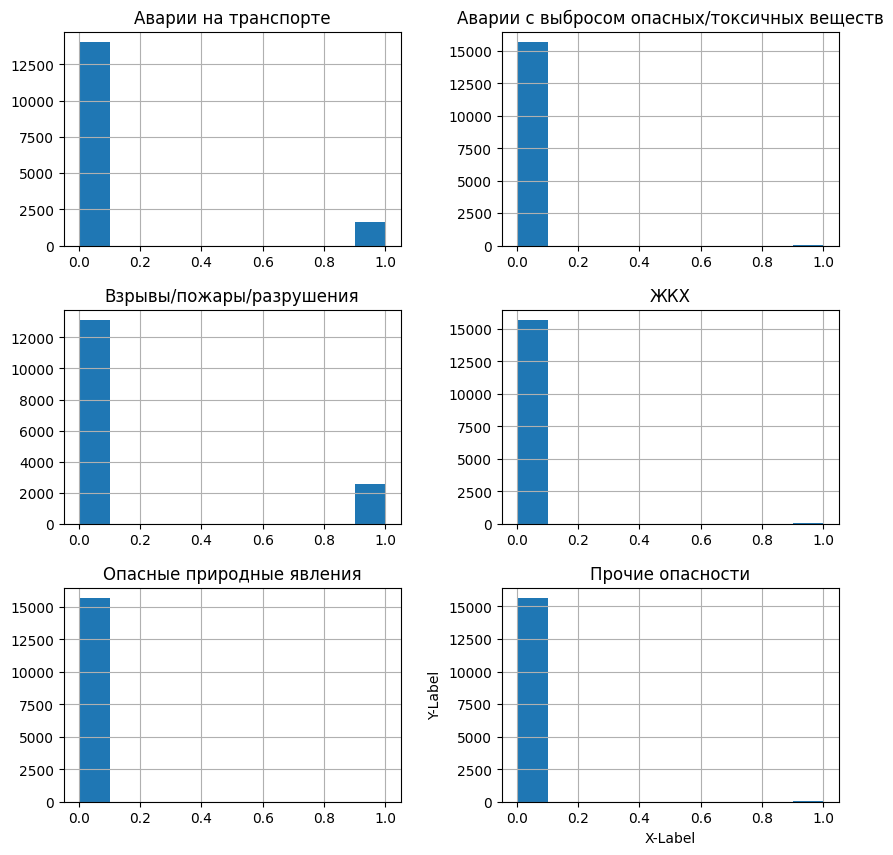

In [103]:
# Тестовая выборка
fig, ax = plt.subplots(figsize=(10, 10))
data_test[y].astype(int).hist(ax=ax)
plt.xlabel('X-Label')
plt.ylabel('Y-Label')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17648\1826887555.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_train[y].astype(int).hist(ax=ax)


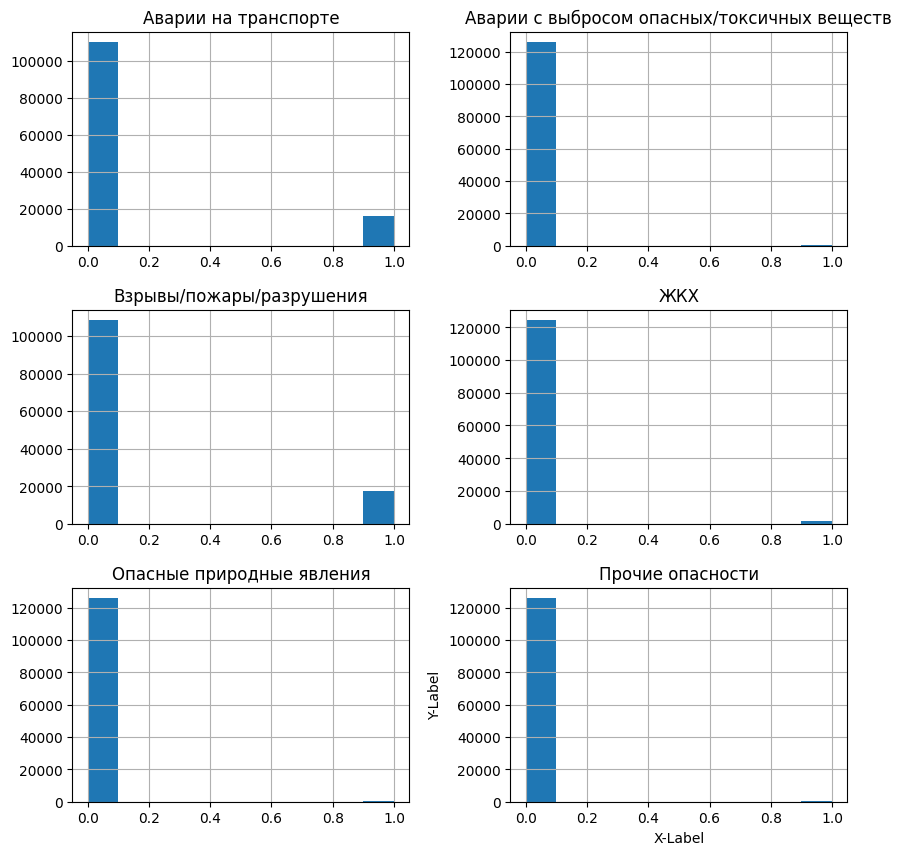

In [104]:
# Обучающая выборка
fig, ax = plt.subplots(figsize=(10, 10))
data_train[y].astype(int).hist(ax=ax)
plt.xlabel('X-Label')
plt.ylabel('Y-Label')
plt.show()

In [105]:
x_train = data_train[x]
y_train = data_train[y]
x_test = data_test[x]
y_test = data_test[y]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((126184, 1215), (15695, 1215), (126184, 6), (15695, 6))

In [106]:
# нормализация данных
class Normalize(object):
    def __call__(self, sample):
        min_val = torch.min(sample)
        max_val = torch.max(sample)
        normalized = (sample - min_val) / (max_val - min_val + 1e-8)
        return normalized
    
class Standardize(object):
    def __call__(self, sample):
        mean = torch.mean(sample)
        std = torch.std(sample)
        standardized = (sample - mean) / (std + 1e-8)
        return standardized
    

class RobustNormalize(object):
    def __call__(self, sample):
        median = torch.median(sample)
        iqr = torch.quantile(sample, 0.75) - torch.quantile(sample, 0.25)
        normalized = (sample - median) / (iqr + 1e-8)
        return normalized
    

data_transform = transforms.Compose([
    #transforms.ToTensor(),
    random.choice([Normalize(),Standardize(), RobustNormalize()])
])
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
# # Разделение на тренировочный и валидационный наборы с учетом дисбаланса классов
# validation_split = 0.1
# dataset_size = len(custom_dataset)
# validation_size = int(validation_split * dataset_size)
# train_size = dataset_size - validation_size

# # Получение индексов для разделения
# indices = list(range(dataset_size))
# random.shuffle(indices)  # Перемешиваем индексы перед разделением
# train_indices, validation_indices = indices[:train_size], indices[train_size:]


In [107]:
def train_classification_model(model, num_epochs, train_loader, valid_loader, device, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight= torch.Tensor([5, 5, 7, 10, 10, 10])).to(device)  # Замените your_weight_tensor на соответствующий тензор весов

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-7)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0

        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        scheduler.step()
        model.eval()
        valid_loss = 0.0

        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

                # Предсказания модели
                _, predicted = torch.max(outputs, 1)
                y_true.extend(targets.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                


        epoch_duration = time.time() - start_time

        print(f"Epoch {epoch + 1} | Train_Loss: {running_loss / len(train_loader):.4f} | Valid_Loss: {valid_loss / len(valid_loader):.4f} | Time: {epoch_duration:.2f} seconds")


In [108]:
class RecurrentImproved(nn.Module):
    def __init__(self, out_dim=1215, hidden_dim=256, num_layers=2, num_classes=6, dropout=0.5):
        super(RecurrentImproved, self).__init__()
        
        self.lstm = nn.LSTM(input_size=out_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.BatchNorm1d(hidden_dim)  # Нормализация
        self.relu = nn.ReLU()  # ReLU
        self.fc = nn.Linear(hidden_dim, num_classes) 

        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.norm(x)  
        x = self.dropout(x)  
        x = self.fc(x)  

        return x

# Инициализация весов
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [109]:
# Обучение модели
num_epochs = 1000
lr = 0.001
batch_size = 10000

In [110]:
model = RecurrentImproved()
model.apply(init_weights)
#загрузка весов модели
model.load_state_dict(torch.load('model_RNN_MES_256.pth'))
# Создание DataLoader для тренировочного и валидационного наборов
num_workers = torch.multiprocessing.cpu_count()  # Использование всех доступных ядер
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(test_dataset, batch_size=batch_size)

In [119]:
train_classification_model(model, num_epochs, train_loader, valid_loader, device, lr)

Epoch 1 | Train_Loss: 1.8604 | Valid_Loss: 1.4622 | Time: 135.53 seconds
Epoch 2 | Train_Loss: 1.8517 | Valid_Loss: 2.1089 | Time: 137.93 seconds
Epoch 3 | Train_Loss: 1.8175 | Valid_Loss: 1.5465 | Time: 136.13 seconds
Epoch 4 | Train_Loss: 1.8313 | Valid_Loss: 1.4190 | Time: 136.87 seconds
Epoch 5 | Train_Loss: 1.9477 | Valid_Loss: 1.8684 | Time: 137.11 seconds
Epoch 6 | Train_Loss: 1.9361 | Valid_Loss: 2.0604 | Time: 137.47 seconds
Epoch 7 | Train_Loss: 1.8455 | Valid_Loss: 2.0256 | Time: 135.86 seconds
Epoch 8 | Train_Loss: 1.8334 | Valid_Loss: 1.4620 | Time: 137.33 seconds
Epoch 9 | Train_Loss: 1.8063 | Valid_Loss: 1.4877 | Time: 135.95 seconds
Epoch 10 | Train_Loss: 1.7997 | Valid_Loss: 1.7417 | Time: 136.74 seconds
Epoch 11 | Train_Loss: 1.7973 | Valid_Loss: 1.4122 | Time: 137.82 seconds
Epoch 12 | Train_Loss: 1.7886 | Valid_Loss: 1.7854 | Time: 139.25 seconds
Epoch 13 | Train_Loss: 1.7896 | Valid_Loss: 1.5311 | Time: 133.62 seconds
Epoch 14 | Train_Loss: 1.7859 | Valid_Loss: 1.6

KeyboardInterrupt: 

In [120]:
torch.save(model.state_dict(), 'model_RNN_MES_256.pth')

Проверка качества модели

In [ ]:
d_rev = {'Александровский муниципальный округ': 'Александровский МО',
 'Бардымский муниципальный округ': 'Бардымский МО',
 'Березовский муниципальный округ': 'Березовский МО',
 'Большесосновский муниципальный округ': 'Большесосновский МО',
 'Верещагинский городской округ': 'Верещагинский ГО',
 'Гайнский муниципальный округ': 'Гайнский МО',
 'муниципальное образование "город Березники"': 'ГО город Березники',
 'Кизеловский городской округ': 'ГО город Кизел',
 'Горнозаводский городской округ': 'Горнозаводский ГО',
 'Губахинский муниципальный округ': 'Губахинский МО',
 'Добрянский городской округ': 'Добрянский ГО',
 'Еловский муниципальный округ': 'Еловский МО',
 'ЗАТО Звездный': 'ЗАТО Звездный',
 'Ильинский городской округ': 'Ильинский ГО',
 'Карагайский муниципальный округ': 'Карагайский МО',
 'Кишертский муниципальный округ': 'Кишертский МО',
 'Косинский муниципальный округ': 'Косинский МО',
 'Кочевский муниципальный округ': 'Кочевский МО',
 'Красновишерский городской округ': 'Красновишерский ГО',
 'Краснокамский городской округ': 'Краснокамский ГО',
 'Кудымкарский муниципальный округ': 'Кудымкарский МО',
 'Куединский муниципальный округ': 'Куединский МО',
 'Кунгурский муниципальный округ': 'Кунгурский МО',
 'Лысьвенский городской округ': 'Лысьвенский ГО',
 'Нытвенский городской округ': 'Нытвенский ГО',
 'Октябрьский городской округ': 'Октябрьский ГО',
 'Ординский муниципальный округ': 'Ординский МО',
 'Осинский городской округ': 'Осинский ГО',
 'Оханский городской округ': 'Оханский ГО',
 'Очерский городской округ': 'Очерский ГО',
 'г. Пермь': 'Пермский ГО',
 'Пермский муниципальный округ': 'Пермский МО',
 'Сивинский муниципальный округ': 'Сивинский МО',
 'Соликамский городской округ': 'Соликамский ГО',
 'Суксунский городской округ': 'Суксунский ГО',
 'Уинский муниципальный округ': 'Уинский МО',
 'Чайковский городской округ': 'Чайковский ГО',
 'Частинский муниципальный округ': 'Частинский МО',
 'Чердынский городской округ': 'Чердынский ГО',
 'Чернушинский городской округ': 'Чернушинский ГО',
 'Чусовской городской округ': 'Чусовской ГО',
 'Юрлинский муниципальный округ': 'Юрлинский МО',
 'Юсьвинский муниципальный округ': 'Юсьвинский МО'}

In [121]:
sub = torch.Tensor()
with torch.no_grad():
    model.eval()
    for inputs, _ in tqdm(valid_loader):
        model = model.to('cpu')
        inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')
        outputs = model(inputs)
        # Применение softmax для получения вероятностей
        probabilities = torch.nn.functional.softmax(outputs, dim=1)       
        sub = torch.cat((sub, probabilities), dim=0)

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_17648\2696626758.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to('cpu')


In [122]:
df_pred = pd.DataFrame(sub.numpy(), columns=y)
df_pred

,Аварии на транспорте,Аварии с выбросом опасных/токсичных веществ,Взрывы/пожары/разрушения,ЖКХ,Опасные природные явления,Прочие опасности
0,7.166526e-07,0.000000e+00,0.999999,6.784384e-28,0.000000e+00,0.000000e+00
1,2.602237e-02,8.651316e-13,0.026081,9.478970e-01,1.055777e-19,8.770099e-11
2,2.372622e-01,1.164274e-05,0.494515,2.681770e-01,7.699828e-08,3.427668e-05
3,2.144739e-01,4.724948e-04,0.668090,1.163186e-01,2.115046e-04,4.332019e-04
4,2.136717e-01,1.603159e-03,0.686449,9.491250e-02,2.151239e-03,1.212208e-03
...,...,...,...,...,...,...
15690,2.661105e-01,1.936289e-03,0.638673,6.925981e-02,8.160827e-03,1.585950e-02
15691,2.659476e-01,1.945183e-03,0.639477,6.968839e-02,7.589319e-03,1.535236e-02
15692,2.660623e-01,1.955091e-03,0.640127,6.981664e-02,7.121293e-03,1.491805e-02
15693,2.757588e-01,4.669394e-03,0.638284,5.609065e-02,9.592619e-03,1.560518e-02


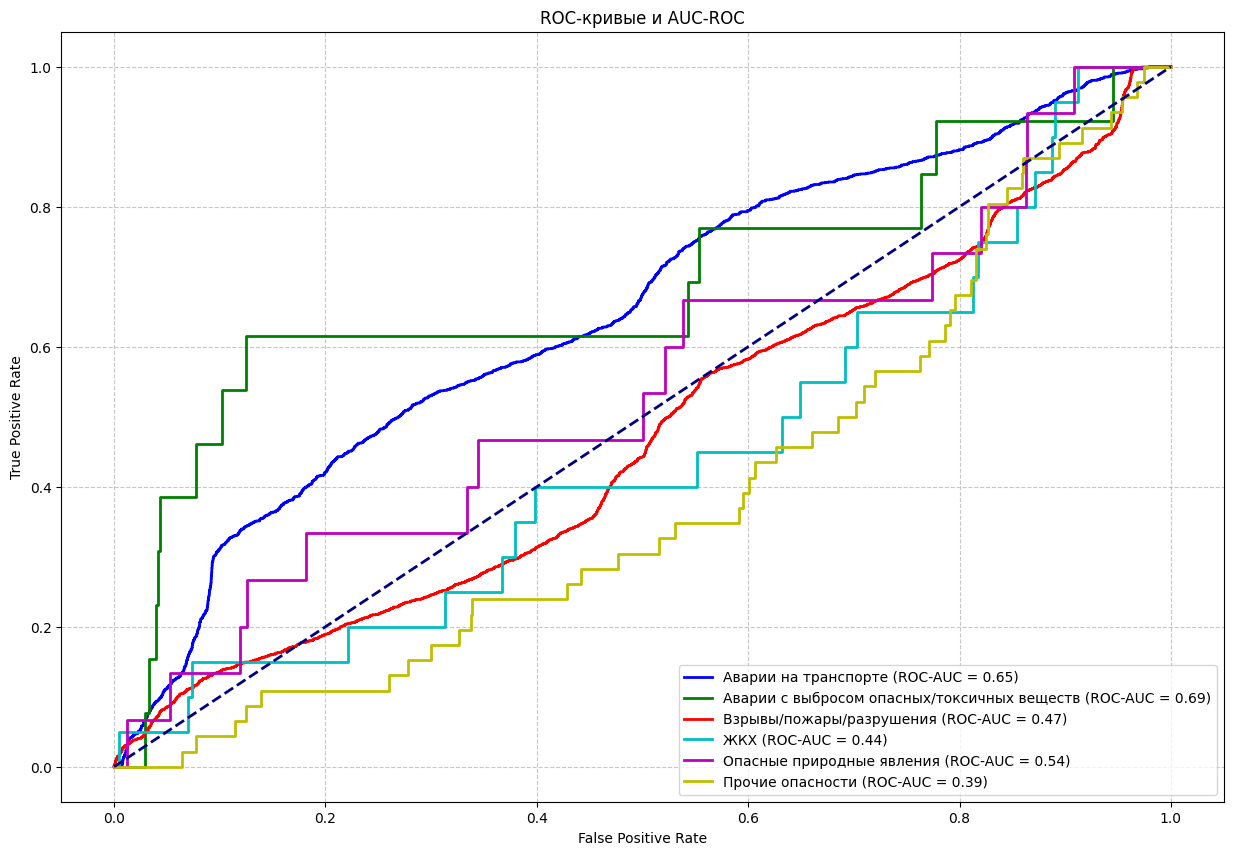

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(15, 10))  
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i, target in enumerate(y):  
    fpr, tpr, thresholds = roc_curve(data_test[target], df_pred[target])
    auc = roc_auc_score(data_test[target], df_pred[target])
    plt.plot(fpr, tpr, lw=2, color=colors[i], label='%s (ROC-AUC = %0.2f)' % (target, auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые и AUC-ROC')
plt.legend(loc="lower right")

# Добавим сетку для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()
